In [1]:
import os
os.environ['PYSPARK_PYTHON'] = '/nfshome/lj1230/.conda/envs/myEnv/bin/python3.5'

from pyspark import SparkContext
sc = SparkContext('local', 'pyspark')

from pyspark.sql.session import SparkSession
spark = SparkSession(sc)

In [2]:
sc

<SparkContext master=local appName=pyspark>

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import seaborn as sns
sns.set(style="whitegrid")

import fiona
import fiona.crs
import shapely
import rtree

import pandas as pd
import geopandas as gpd

import warnings
warnings.filterwarnings(action="once")

/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
# This is to load the shape file
shapefile = 'ZillowNeighborhoods-NY/ZillowNeighborhoods-NY.shp'

# And project it into EPSG:2263 (NAD 83 NY State) plane
neighborhoods = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2263))

In [5]:
neighborhoods.head()

,STATE,COUNTY,CITY,NAME,REGIONID,geometry
0,NY,Monroe,Rochester,Ellwanger-Barry,343894.0,"POLYGON ((19805.35711778845 1099961.05355486, ..."
1,NY,New York,New York City-Manhattan,West Village,270964.0,"POLYGON ((980372.9910645633 205202.4799663476,..."
2,NY,Kings,New York City-Brooklyn,Bensonhurst,193285.0,"POLYGON ((978233.4712775955 159030.8800673813,..."
3,NY,Erie,Buffalo,South Park,270935.0,POLYGON ((-311815.6157876701 1012190.261676005...
4,NY,New York,New York City-Manhattan,East Village,270829.0,"POLYGON ((987758.593831465 206590.82743873, 99..."


In [6]:
# We construct an R-Tree by going through the geometries of the
# shapefiles (i.e. the polygons in the 'geomtry' column). We only 
# use the bounds, not the actual geometry, and the key for each 
# bound is the index into the neighborhood name
index = rtree.Rtree()
for idx,geometry in enumerate(neighborhoods.geometry):
    index.insert(idx, geometry.bounds)

In [7]:
# This is the bounding box of all neighborhoods (in NAD 83 projection)
index.bounds

[-331110.02592820046,
 119967.03773856077,
 1067432.6651321745,
 1150191.636787515]

In [9]:
# The code below will go through the greentaxi.csv file, and:
# (1) Select the trips happened between 10a and 11a.
# (2) Map pick-up locations to neighborhoods using the index above
# (3) Count the trips per neighborhood

import csv
import pyproj
import shapely.geometry as geom


proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    

counts = {}
with open('yellow.csv', 'r') as fi:
    reader = csv.reader(fi)
    print(next(reader)) # Skip the header
    for row in reader:
        pdt = row[0].split(' ')[1].split(':')[0]
        if pdt!='10': continue # skip all records != around 10:xx pickup
        p = geom.Point(proj(float(row[3]), float(row[2])))
        match = None
        for idx in index.intersection((p.x, p.y, p.x, p.y)):
            # idx is in the list of shapes that might match
            if neighborhoods.geometry[idx].contains(p):
                match = idx
                break
        if match:
            counts[match] = counts.get(match, 0) + 1

['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']


/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


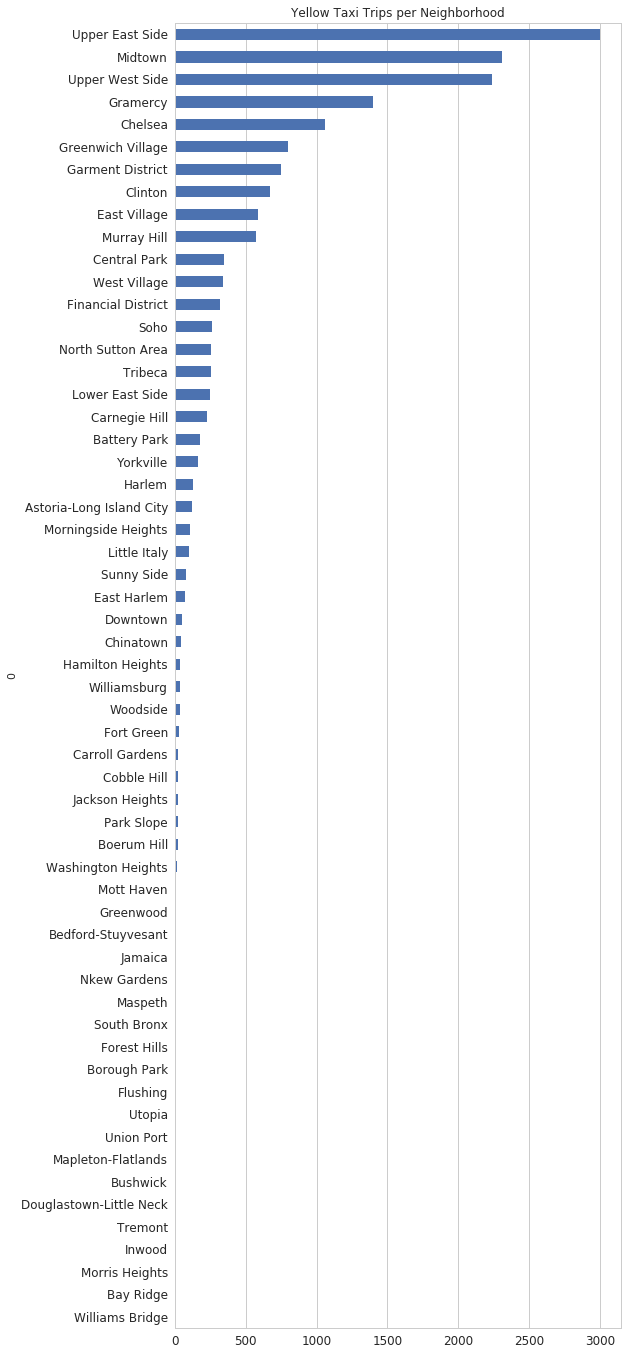

In [17]:
# We create a list consisting of neighborhood names, and counts
countsPerNeighborhood = list(map(
    lambda x: (neighborhoods['NAME'][x[0]], x[1]),
    counts.items()))

# Then we plot using pandas
df = pd.DataFrame(countsPerNeighborhood).sort_values(1).set_index(0)
ax = df.plot(kind='barh', title='Yellow Taxi Trips per Neighborhood', 
             figsize=(8,24), fontsize=12, legend=False)
ax.yaxis.grid(False)

In [18]:
# We perform the same task using Spark. Here we run the task in
# parallel on each partition (chunk of data). For each task, we
# have to re-create the R-Tree since the index cannot be shared
# across partitions. Note: we have to import the package inside
# processTrips() to respect the closure property.

def processTrips(pid, records):
    if pid==0:
        next(records)
    counts = {}
    import rtree
    reader = csv.reader(records)
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    shapefile = 'ZillowNeighborhoods-NY/ZillowNeighborhoods-NY.shp'
    neighborhoods = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2263))
    index = rtree.Rtree()
    for idx,geometry in enumerate(neighborhoods.geometry):
        index.insert(idx, geometry.bounds)
    for row in reader:
        pdt = row[0].split(' ')[1].split(':')[0]
        if pdt!='10':
            continue
        p = geom.Point(proj(float(row[3]), float(row[2])))
        match = None
        for idx in index.intersection((p.x, p.y, p.x, p.y)):
            shape = neighborhoods.geometry[idx]
            if shape.contains(p):
                match = idx
                break
        if match:
            counts[match] = counts.get(match, 0) + 1
    return counts.items()
            
rdd = sc.textFile('yellow.csv')
counts = rdd.mapPartitionsWithIndex(processTrips) \
            .reduceByKey(lambda x,y: x+y) \
    .collect()
len(counts)


/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/socket.py:647: ResourceWarning: unclosed <socket.socket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59504), raddr=('127.0.0.1', 41444)>
  self._sock = None


58

In [19]:
# It's usually better to factor things out for readability

def createIndex(shapefile):
    import rtree
    import fiona.crs
    import geopandas as gpd
    zones = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2263))
    index = rtree.Rtree()
    for idx,geometry in enumerate(zones.geometry):
        index.insert(idx, geometry.bounds)
    return (index, zones)

def findZone(p, index, zones):
    match = index.intersection((p.x, p.y, p.x, p.y))
    for idx in match:
        if zones.geometry[idx].contains(p):
            return idx
    return None

def processTrips(pid, records):
    import csv
    import pyproj
    import shapely.geometry as geom
    
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    
    index, zones = createIndex('ZillowNeighborhoods-NY/ZillowNeighborhoods-NY.shp')    
    
    if pid==0:
        next(records)
    reader = csv.reader(records)
    counts = {}
    
    for row in reader:
        pdt = row[0].split(' ')[1].split(':')[0]
        if pdt!='10':
            continue
        p = geom.Point(proj(float(row[3]), float(row[2])))
        zone = findZone(p, index, zones)
        if zone:
            counts[zone] = counts.get(zone, 0) + 1
    return counts.items()
            
rdd = sc.textFile('yellow.csv')
counts = rdd.mapPartitionsWithIndex(processTrips) \
            .reduceByKey(lambda x,y: x+y) \
            .collect()
len(counts)


/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/socket.py:647: ResourceWarning: unclosed <socket.socket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57628), raddr=('127.0.0.1', 46001)>
  self._sock = None


58

/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


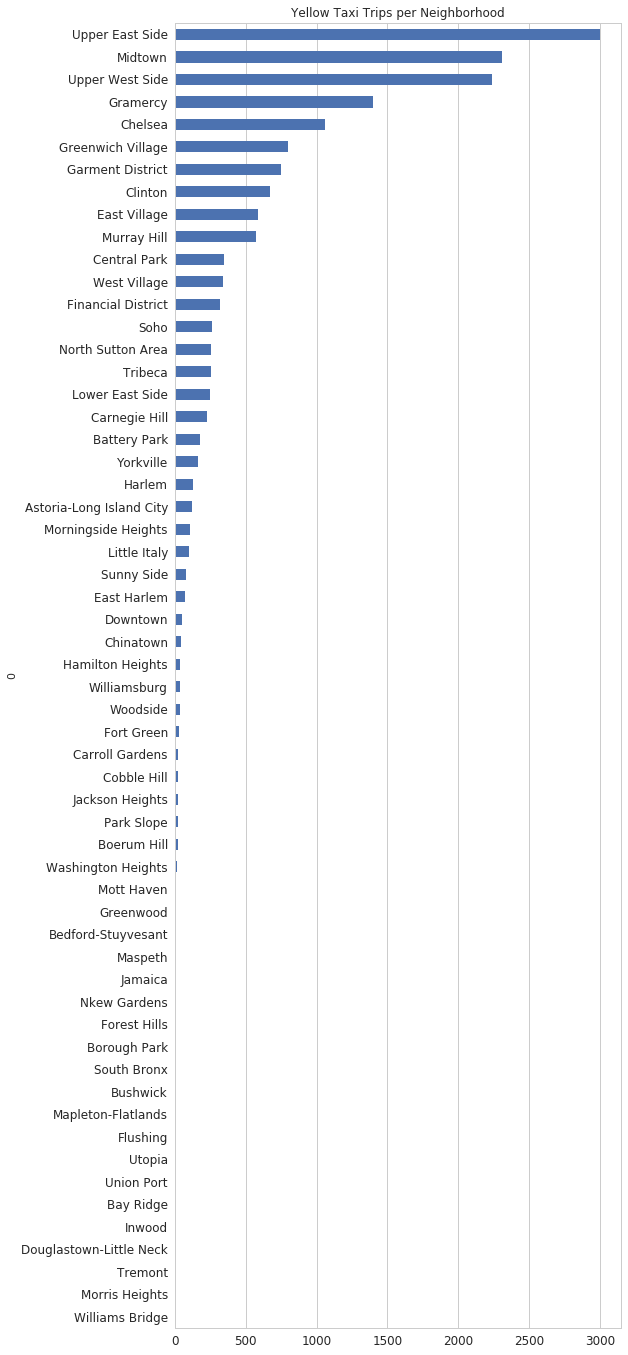

In [20]:
countsPerNeighborhood = list(map(lambda x: (neighborhoods['NAME'][x[0]], x[1]), counts))
df = pd.DataFrame(countsPerNeighborhood).sort_values(1).set_index(0)
ax = df.plot(kind='barh', title='Yellow Taxi Trips per Neighborhood', figsize=(8,24), fontsize=12, legend=False)
ax.yaxis.grid(False)

In [2]:
sc.textFile('/nfshome/lj1230/2019_Spring_BDM/Lab5/book.txt').flatMap(lambda x: x.split()).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).take(5)

NameError: name 'sc' is not defined